In [2]:
import sys
!conda install --yes --prefix {sys.prefix} pandasql

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pandasql


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py39hf3d152e_1         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         145 KB

The following NEW packages will be INSTALLED:

  pandasql           conda-forge/noarch::pandasql-0.7.3-pyhd8ed1ab_0

The following packages will be UPDATED:

  ca-certificates                      2021.5.30-ha878542_0 --> 2021.10.8-ha878542_0
  certifi                          2021.5.30-py39hf3d152e_0 --> 2021.10.8-py39hf3d152e_1
  openssl                                 1.1.1k-h7f98852_1 --> 1.1.1l-h7f98852_0



certifi-2021.10.8    | 145 KB    | ##################################### | 100% 
Preparing transaction: d

In [3]:
import pandas as p
from pandasql import sqldf
from sklearn.model_selection import train_test_split
pysqldf = lambda q: sqldf(q, globals())

In [4]:
df_people = p.read_csv('../data/People.csv')
df_salaries = p.read_csv('../data/Salaries.csv')
df_appearances = p.read_csv('../data/Appearances.csv')
df_batting = p.read_csv('../data/Batting.csv')
df_fielding = p.read_csv('../data/Fielding.csv')


(0.0, 0.5)

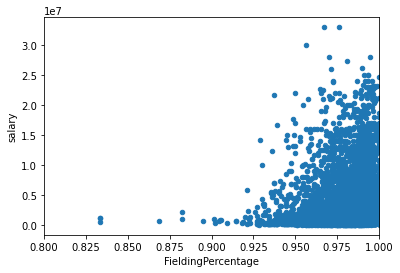

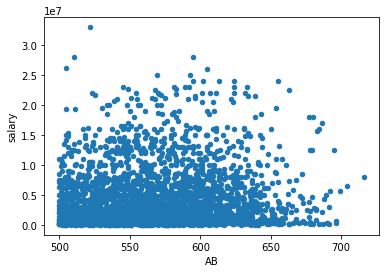

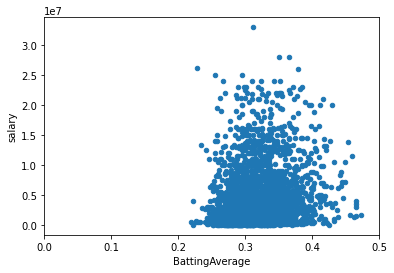

In [73]:
df_playerids = pysqldf("SELECT DISTINCT playerID from df_people group by playerID")
df_playerids.head(5)

batting_stats = pysqldf("""
    SELECT playerID, yearID, G, H / (AB - BB - SF) as BattingAverage, AB, R, H, HR, RBI, BB, SF 
    FROM df_batting 
    WHERE G >= 50 and AB > 0 and yearID > 1955
""")

player_salaries = pysqldf("""
    SELECT stats.playerID, stats.yearID, df_salaries.salary, G, BattingAverage, AB, R, H, HR, RBI, BB, SF
    FROM batting_stats as stats
    INNER JOIN df_salaries ON df_salaries.playerID = stats.playerID AND df_salaries.yearID = stats.yearID
""")

fielders = pysqldf("""
    SELECT DISTINCT ps.playerID, ps.yearID, salary, POS, ps.G, BattingAverage, AB, R, H, HR, RBI, BB, SF, (PO + A) / (PO + A + E) as FieldingPercentage, A, E, PO
    FROM player_salaries AS ps
    INNER JOIN df_fielding ON ps.playerID=df_fielding.playerID AND ps.yearID=df_fielding.yearID 
""")

# fielders.head(5)

updated = fielders.groupby(['playerID', 'yearID']).agg({
    'G': ['first'],
    'AB': ['first'],
    'H': ['first'],
    'HR': ['first'],
    'RBI': ['first'],
    'BB': ['first'],
    'SF': ['first'],
    'A': ['sum'],
    'E': ['sum'],
    'PO': ['sum'],
    'salary': ['first']
})
updated['FieldingPercentage'] = (updated['A'] + updated['PO']) / (updated['PO'] + updated['A'] + updated['E'])
updated['BattingAverage'] = updated['H'] / (updated['AB'] - updated['BB'] - updated['SF'])
updated.columns = updated.columns.droplevel(1)

fp_ax = updated[ updated['G'] >= 100].plot.scatter(x="FieldingPercentage", y="salary")
fp_ax.set_xlim(0.8, 1)

updated[ updated['AB'] >= 500 ].plot.scatter(x="AB", y="salary")
ba_ax = updated[ updated['AB'] >= 500 ].plot.scatter(x="BattingAverage", y="salary")
ba_ax.set_xlim(0, 0.5)